# Multiclass text classification using BERT
- toc: true
- badges: true
- categories: [Natural Language Processing, Hugging Face]
- permalink: /bert-multiclass-text-classification/
- description: a tutorial on mult-class text classfication using pretrained BERT model from HuggingFace

In this post, we'll do a simple text classification task using the pretained [BERT model]((https://huggingface.co/docs/transformers/model_doc/bert) from HuggingFace.

The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805), by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.


In [ ]:
#hide
!pip install transformers

In [ ]:
#hide
import warnings
warnings.filterwarnings("ignore")

In [1]:
#hide
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from transformers import AdamW, get_linear_schedule_with_warmup
# from torch.nn.utils import clip_grad_norm_
# from datasets import load_dataset
# #from sklearn.model_selection import train_test_split
import pandas as pd
# import numpy as np
# from tqdm.notebook import tqdm


# # compute metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# import seaborn as sb

## Loading data



In [2]:

PRETRAINED_LM = "dbmdz/bert-base-turkish-uncased"
%mkdir PRI_TR
TB_path="/content/PRI_TR"

In [3]:
def build_data(in_file,POS):

    import csv

    max_length=0

    # Open the input file in read mode
    input_file = open(in_file+".conllu", "r")

    # Create an empty list to store the lines
    words = ""
    root= ""
    csv_line=[]



    with open(in_file+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["text","label"])
        root_found=False
        # Loop through each line in the input file
        c=0
        for line in input_file:

          if line!="\n":
                words=words+(line.split()[1])+" "
                if line.split()[6]=="0" and not root_found:
                  root=POS[line.split()[3]]
                  root_found=True

          else:
                c+=1
                full_text=words[0:-1]
                root_found=False
                if len(words)>max_length: max_length= len(words.split(" "))
                csv_line.append(full_text)
                csv_line.append(str(root))
                writer.writerow(csv_line)


                csv_line=[]
                words = ""
                root= ""

    print('max_length',max_length,"\n","count of examples:",c)
    # Close the input file
    input_file.close()




In [4]:

POS={}
label_names=set()

for f in ["train","dev","test"]:
   temp_pos=set()
   input_file = open(f+".conllu", "r")
   for line in input_file:
    if line!="\n":
      if line.split()[6]=="0":
        label_names.add(line.split()[3])
        temp_pos.add(line.split()[3])
   print(f,len(temp_pos),"\n",temp_pos)

label_names=list(label_names)
for i in range(len(label_names)):
  POS[label_names[i]]=i



build_data("/content/train",POS)
build_data("/content/dev",POS)
build_data("/content/test",POS)


N_labels = len(label_names)
print(POS)
print(label_names)
print("N_labels: ",N_labels)

train_df=pd.read_csv("train.csv")
valid_df=pd.read_csv("dev.csv")
test_df=pd.read_csv("test.csv")

def count_pos(df,df_name):
    print("\n ---", df_name,"---\n")
    for i in range(N_labels):
        counter = len(df.loc[df['label'] == i])
        print(i,counter)

count_pos(train_df,"train")
count_pos(valid_df,"dev")
count_pos(test_df,"test")

train 13 
 {'DET', 'NUM', 'ADJ', 'AUX', 'PROPN', 'ADV', 'PRON', 'VERB', 'PUNCT', 'CCONJ', 'X', 'NOUN', 'ADP'}
dev 11 
 {'DET', 'NUM', 'ADJ', 'PROPN', 'ADV', 'PRON', 'VERB', 'PUNCT', 'CCONJ', 'NOUN', 'ADP'}
test 13 
 {'DET', 'NUM', 'ADJ', 'AUX', 'PROPN', 'ADV', 'PRON', 'VERB', 'PUNCT', 'CCONJ', 'X', 'NOUN', 'ADP'}
max_length 37 
 count of examples: 3685
max_length 17 
 count of examples: 975
max_length 31 
 count of examples: 975
{'DET': 0, 'NUM': 1, 'ADJ': 2, 'AUX': 3, 'PROPN': 4, 'ADV': 5, 'PRON': 6, 'VERB': 7, 'PUNCT': 8, 'CCONJ': 9, 'X': 10, 'NOUN': 11, 'ADP': 12}
['DET', 'NUM', 'ADJ', 'AUX', 'PROPN', 'ADV', 'PRON', 'VERB', 'PUNCT', 'CCONJ', 'X', 'NOUN', 'ADP']
N_labels:  13

 --- train ---

0 1
1 19
2 343
3 16
4 38
5 57
6 47
7 2483
8 9
9 13
10 2
11 648
12 9

 --- dev ---

0 1
1 3
2 97
3 0
4 14
5 15
6 15
7 653
8 4
9 2
10 0
11 168
12 3

 --- test ---

0 1
1 2
2 83
3 6
4 15
5 10
6 10
7 653
8 2
9 1
10 1
11 189
12 2


In [ ]:
train_df.head()

,text,label
0,Sanal parçacıklar sa bunların hiçbirini yapama...,5
1,Ona her şeyimi verdim .,5
2,"Karşısında , pantolonu dizlerine dek ıslak , ö...",5
3,Nereden biliyorsunuz .,5
4,Aradığımı Buldum Sandım .,5


## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='dbmdz/bert-base-turkish-uncased', vocab_size=32000, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

define a function for encoding:

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

Use the `ecode` function to get input ids and attention masks of the datasets:

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

We'll use pytorch `Dataset` and `DataLoader` to split data into batches. For more detatils, you can check out another post on [DataLoader](https://www.intodeeplearning.com/how-to-load-datasets-from-hugging-face-datasets/).

Turn the labels into tensors:

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([3685]), torch.Size([975]), torch.Size([975]))

Create dataloaders for training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 64
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

We will initiate the  `BertForSequenceClassification ` model from Huggingface, which allows easily fine-tuning the pretrained BERT mode for classification task.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

An **optimizer** is for tuning parameters in the model, which is set up with a learning rate.

Selection of the learning rate is important. In practice, it's common to use a **scheduler** to decrease the learning rate during training.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task.

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 2.133293287507419 
16/16 val loss: 1.728324368596077 
Epoch:  2


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 1.4586507760245224 
16/16 val loss: 1.2317387759685516 
Epoch:  3


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 1.1574985682964325 
16/16 val loss: 1.0808186568319798 
Epoch:  4


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 1.0456790143045886 
16/16 val loss: 0.9978554546833038 
Epoch:  5


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.9671125617520563 
16/16 val loss: 0.9316361844539642 
Epoch:  6


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.9081345395795231 
16/16 val loss: 0.9028076976537704 
Epoch:  7


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.8724069245930376 
16/16 val loss: 0.8803450539708138 
Epoch:  8


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.8452228872940458 
16/16 val loss: 0.8590162359178066 
Epoch:  9


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.8260908167937706 
16/16 val loss: 0.867754589766264 
Epoch:  10


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.8038453094918152 
16/16 val loss: 0.8466549851000309 
Epoch:  11


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.7872058579633976 
16/16 val loss: 0.8353185318410397 
Epoch:  12


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.7789034781784847 
16/16 val loss: 0.840153880417347 
Epoch:  13


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.7676002660702015 
16/16 val loss: 0.821358609944582 
Epoch:  14


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.7497691357957905 
16/16 val loss: 0.8136720359325409 
Epoch:  15


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.7349584195120581 
16/16 val loss: 0.8096029385924339 
Epoch:  16


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.7201433603105873 
16/16 val loss: 0.8027260936796665 
Epoch:  17


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.7082772244667185 
16/16 val loss: 0.7960039488971233 
Epoch:  18


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6977743809593135 
16/16 val loss: 0.795759454369545 
Epoch:  19


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6841091970945227 
16/16 val loss: 0.7882881946861744 
Epoch:  20


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.676550286597219 
16/16 val loss: 0.7896550893783569 
Epoch:  21


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6697532889144174 
16/16 val loss: 0.7889008782804012 
Epoch:  22


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.65860357007076 
16/16 val loss: 0.7824693880975246 
Epoch:  23


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6467659031522686 
16/16 val loss: 0.788710743188858 
Epoch:  24


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6458797454833984 
16/16 val loss: 0.7804257087409496 
Epoch:  25


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6411634688747341 
16/16 val loss: 0.7798654586076736 
Epoch:  26


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6366520148926768 
16/16 val loss: 0.7777760550379753 
Epoch:  27


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6322379112243652 
16/16 val loss: 0.780480220913887 
Epoch:  28


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6322487006927359 
16/16 val loss: 0.7798609957098961 
Epoch:  29


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6271922927478264 
16/16 val loss: 0.7779738903045654 
Epoch:  30


Training:   0%|          | 0/58 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

58/58 train loss: 0.6279208315857525 
16/16 val loss: 0.7793184481561184 


You can see in the output that the training and validation losses steadily decreases in each epoch.

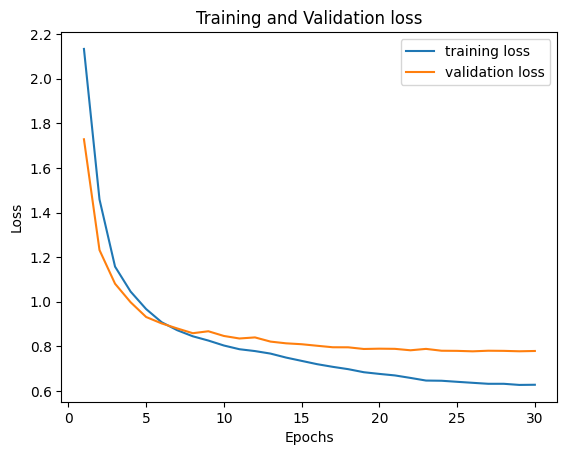

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [ ]:
from sklearn.metrics import classification_report
#print('classifiation report')
#print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

## Error Analysis
With the predictions, we can plot the confusion matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [ ]:
#plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=label_names)

You can see that **sadness** has a higher likelihood to be classified as **anger** or **fear**, leading to a lower f1 score.

<br>

## Prediction

*Now* let's use the trained model to predict the testing set.

In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')


print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

With the predictions, we can plot the confusion matrix again:

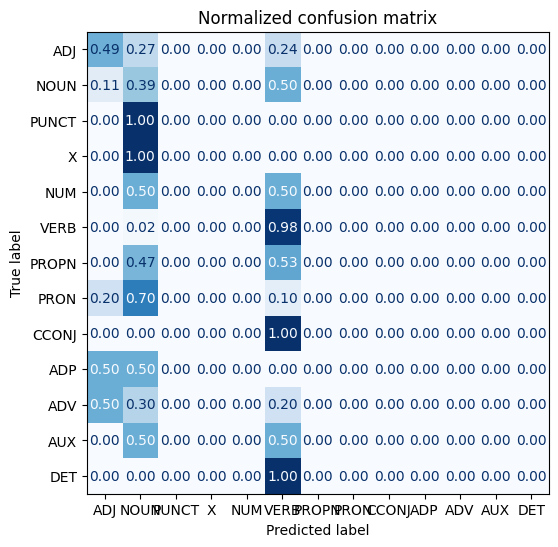

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=label_names)

Output the misclassified text:

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(224, 3)


,text,label,pred
5,Maziyle bağlarını koparıyor .,1,5
9,Niçin .,10,0
10,ŞARKICIYI yakından görmek için gelen lerin izd...,10,5
13,Bana kim buyurdu : Manastıra git ! Kulunuz .,1,5
16,Fransa'nın güneybatısında .,0,1
18,Bebeler muradına erdi .,1,5
24,Her istediğini yerine getiriyordum .,1,5
28,Uzun vade li yatırımcı için ellibeş sent seviy...,1,0
36,İyi akşamlar ...,0,1
40,Tazminat almak amacından öte asıl amaç belgele...,5,1


In [ ]:
#hide

test_df.to_csv(TB_path+"/test_results.csv",index= False)
valid_df.to_csv(TB_path+"/dev_results.csv",index= False)

In [ ]:



from google.colab import files
%cd /content/

!zip -r PRI_TR.zip PRI_TR
files.download('PRI_TR.zip')


/content
  adding: PRI_TR/ (stored 0%)
  adding: PRI_TR/dev_results.csv (deflated 58%)
  adding: PRI_TR/test_results.csv (deflated 59%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>